In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import sparse
from sklearn.cluster import spectral_clustering, KMeans
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D

In [2]:
import seaborn as sns
#sns.set_style("darkgrid")

In [3]:
from sklearn.model_selection import train_test_split

In [106]:
#from sklearn.preprocessing import OneHotEncoder

In [5]:
import xgboost as xgb

In [6]:
df = pd.read_csv('open_fda_merged.csv')

## Selecting event with a serious occurence
seriousness_df =df.loc[df["serious"] == 1]

## Adding a weight to event associated with death
seriousness_df.loc[:, "seriousnessdeath"] = 5 * seriousness_df.loc[:, "seriousnessdeath"]


## Recovering the sum of the severity type for events
## Question: Shall we include congenital anomalies ?!?!
seriousness_df.loc[:, "serious_count"] = seriousness_df[["seriousnesscongenitalanomali", 
                                                  "seriousnessdeath", 
                                                  "seriousnessdisabling",
                                                  "seriousnesshospitalization",
                                                  "seriousnesslifethreatening",
                                                  "seriousnessother"]].sum(axis=1)
                                                  

# Creating dummy matrix of drugs
drug_df = pd.get_dummies(seriousness_df.medicinalproduct)
drugs_columns = drug_df.columns

## Merging the dataframe linking drugs and the count of adverse events
dff = pd.merge(seriousness_df["reactionmeddrapt"].reset_index(), drug_df.reset_index(), on="index")
dff.drop(labels="index", axis=1, inplace=True)
dff = dff.groupby("reactionmeddrapt")[drugs_columns].max().reset_index()

## Saving the dataframe
## dff.to_csv('cleaned_output/drug_vs_fdadv_evt.csv')

/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/opt/conda/lib/python3.6/site-packages/pandas/core/indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/opt/conda/lib/python3.6/site-packages/pandas/core/indexing.py:357: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)


In [13]:
dff.shape

(13910, 329)

In [18]:
print(dff[dff["reactionmeddrapt"].duplicated()])

Empty DataFrame
Columns: [reactionmeddrapt, 5-fluorouracil, abarelix, abatacept, acebutolol, aclarubicin, actinomycin d, adalimumab, adriamycin, aldesleukin, alefacept, alemtuzumab, aliskiren, alprenolol, altretamine, ambrisentan, amiloride, aminoglutethimide, aminolevulinic acid, aminopterin, amlodipine, amrubicin, amsacrine, anagrelide, anakinra, anastrozole, apremilast, arsenic trioxide, asparaginase erwinia chrysanthemi, atenolol, atorvastatin, axitinib, azacitidine, azathioprine, basiliximab, belatacept, belimumab, benazepril, bendroflumethiazide, bepridil, betaxolol, bevantolol, bexarotene, bezafibrate, bibw 2992, bicalutamide, bisoprolol, bleomycin, bortezomib, bosentan, bosutinib, brentuximab vedotin, bumetanide, buserelin acetate, busulfan, cabazitaxel, canakinumab, candesartan, capecitabine, captopril, carboplatin, carfilzomib, carmustine, carteolol, carvedilol, catumaxomab, celecoxib, celiprolol hcl, cerivastatin, cetuximab, chlorambucil, chlorothiazide, chlorpropamide, chlo

In [20]:
AEs = dff["reactionmeddrapt"].tolist()

In [41]:
dffT = dff.set_index("reactionmeddrapt").T

In [42]:
print(dffT.head())

reactionmeddrapt  11-beta-hydroxylase deficiency  \
5-fluorouracil                                 0   
abarelix                                       0   
abatacept                                      0   
acebutolol                                     0   
aclarubicin                                    0   

reactionmeddrapt  17-alpha-hydroxylase deficiency  \
5-fluorouracil                                  0   
abarelix                                        0   
abatacept                                       0   
acebutolol                                      0   
aclarubicin                                     0   

reactionmeddrapt  17-hydroxyprogesterone increased  \
5-fluorouracil                                   0   
abarelix                                         0   
abatacept                                        0   
acebutolol                                       0   
aclarubicin                                      0   

reactionmeddrapt  5-hydroxyindolacetic acid

In [44]:
#X = dff[drugs_columns].values
X = dffT.values

In [45]:
X

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

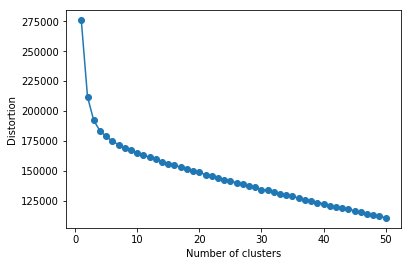

In [46]:
distortions = []
for i in range(1, 51):
    kmean = KMeans(n_clusters=i,
                   n_init=100,
                   verbose=0,
                   n_jobs=-1)
    kmean.fit(X)
    distortions.append(kmean.inertia_)
    
plt.plot(range(1, 51), distortions, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.show()

In [47]:
## K-means clustering of adverse events
nb_clusters = 50
kmean = KMeans(n_clusters = nb_clusters,
               n_init=100,
               verbose=0,
               n_jobs=-1)

#dff["cluster"] = kmean.fit_predict(dff[drugs_columns])
dffT["cluster"] = kmean.fit_predict(X)

In [50]:
dffT.columns

Index(['11-beta-hydroxylase deficiency', '17-alpha-hydroxylase deficiency',
       '17-hydroxyprogesterone increased',
       '5-hydroxyindolacetic acid in urine',
       '5-hydroxyindolacetic acid in urine decreased',
       '5-hydroxyindolacetic acid in urine increased',
       '5-hydroxyindolacetic acid increased', '5q minus syndrome', 'abasia',
       'abdomen crushing',
       ...
       'yellow skin', 'yersinia bacteraemia', 'yersinia infection',
       'yersinia test positive', 'yolk sac tumour site unspecified',
       'zika virus infection', 'zinc deficiency',
       'zinc sulphate turbidity increased', 'zygomycosis', 'cluster'],
      dtype='object', name='reactionmeddrapt', length=13911)

In [51]:
dffT.index

Index(['5-fluorouracil', 'abarelix', 'abatacept', 'acebutolol', 'aclarubicin',
       'actinomycin d', 'adalimumab', 'adriamycin', 'aldesleukin', 'alefacept',
       ...
       'vandetanib', 'vemurafenib', 'verapamil', 'vinblastine', 'vincristine',
       'vindesine', 'vinflunine', 'vinorelbine', 'vismodegib', 'vorinostat'],
      dtype='object', length=328)

In [52]:
seriousness_df.columns

Index(['Unnamed: 0', 'safetyreportid', 'drugcharacterization',
       'medicinalproduct', 'patientonsetage', 'patientonsetageunit',
       'patientsex', 'patientweight', 'patient_age', 'reactionmeddrapt',
       'receiptdate', 'serious', 'seriousnesscongenitalanomali',
       'seriousnessdeath', 'seriousnessdisabling',
       'seriousnesshospitalization', 'seriousnesslifethreatening',
       'seriousnessother', 'serious_count'],
      dtype='object')

In [53]:
seriousness_df["medicinalproduct"].head()

0      clonidine
1    simvastatin
2    simvastatin
3     belatacept
4      diltiazem
Name: medicinalproduct, dtype: object

In [54]:
seriousness_df.shape

(3705466, 19)

In [55]:
dffT.shape

(328, 13911)

In [60]:
dffT.reset_index(inplace=True)
dffT.rename(columns={"index":"medicinalproduct"}, inplace=True)

In [61]:
seriousness_dff = pd.merge(seriousness_df, dffT[["medicinalproduct", "cluster"]], on="medicinalproduct")

seriousness_dff.shape
## Saving the dataframe
## seriousness_df.to_csv('1.Clustering/open_fda_merged_cluster.csv')

(3705466, 20)

In [63]:
seriousness_dff.columns

Index(['Unnamed: 0', 'safetyreportid', 'drugcharacterization',
       'medicinalproduct', 'patientonsetage', 'patientonsetageunit',
       'patientsex', 'patientweight', 'patient_age', 'reactionmeddrapt',
       'receiptdate', 'serious', 'seriousnesscongenitalanomali',
       'seriousnessdeath', 'seriousnessdisabling',
       'seriousnesshospitalization', 'seriousnesslifethreatening',
       'seriousnessother', 'serious_count', 'cluster'],
      dtype='object')

In [62]:
print(seriousness_dff.tail())

         Unnamed: 0 safetyreportid  drugcharacterization   medicinalproduct  \
3705461     4061978       14026748                   2.0  sulfametopyrazine   
3705462     4061979       14026748                   2.0  sulfametopyrazine   
3705463     4061980       14026748                   2.0  sulfametopyrazine   
3705464     4061981       14026748                   2.0  sulfametopyrazine   
3705465     4145867       14194587                   1.0         lonidamine   

         patientonsetage  patientonsetageunit  patientsex  patientweight  \
3705461             53.0                801.0         2.0          73.47   
3705462             53.0                801.0         2.0          73.47   
3705463             53.0                801.0         2.0          73.47   
3705464             53.0                801.0         2.0          73.47   
3705465              NaN                  NaN         NaN            NaN   

         patient_age       reactionmeddrapt receiptdate  serious  \


# PCA (n = 3) on cluster

In [82]:
pca = PCA(n_components=3)

In [83]:
X_reduced = pca.fit_transform(X)

In [84]:
X.shape

(328, 13910)

In [85]:
pca.components_.shape

(3, 13910)

In [86]:
len(AEs)

13910

In [87]:
df_comp = pd.DataFrame(pca.components_, columns=AEs)

In [88]:
df_comp.reset_index(inplace=True)
df_comp.rename(columns={"index":"PCA_feature"}, inplace=True)

In [89]:
print(df_comp)

   PCA_feature  11-beta-hydroxylase deficiency  \
0            0                        0.000596   
1            1                       -0.000465   
2            2                        0.003282   

   17-alpha-hydroxylase deficiency  17-hydroxyprogesterone increased  \
0                         0.001450                          0.000266   
1                         0.004212                         -0.000356   
2                         0.001016                          0.000696   

   5-hydroxyindolacetic acid in urine  \
0                            0.000502   
1                            0.001537   
2                           -0.000172   

   5-hydroxyindolacetic acid in urine decreased  \
0                                      0.002132   
1                                      0.004289   
2                                     -0.000123   

   5-hydroxyindolacetic acid in urine increased  \
0                                      0.001136   
1                                     

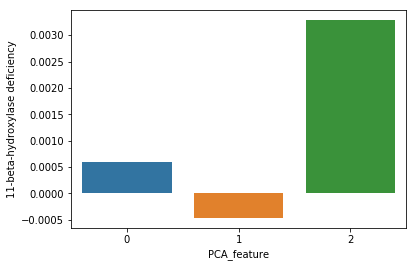

In [90]:
# visualize pca with bar chart
sns.barplot(y=AEs[0], x="PCA_feature", data=df_comp)

In [91]:
pca.components_

array([[ 0.00059617,  0.00144993,  0.00026596, ...,  0.00127669,
         0.00061118,  0.00742373],
       [-0.000465  ,  0.00421169, -0.00035605, ...,  0.0030979 ,
         0.00234271, -0.00682684],
       [ 0.0032822 ,  0.00101604,  0.00069644, ..., -0.0005872 ,
         0.00150763,  0.03783105]])

In [95]:
X_reduced[:5]

array([[ 11.62352886,  -8.44877114,   3.16860195],
       [-16.39468864,   6.01672593,   1.02064978],
       [ 19.93009537,   0.2254063 ,  -3.84692103],
       [  1.77910871,  -5.35515646,  -5.82571997],
       [-14.91041903,   4.13790727,   1.28800806]])

In [96]:
y = dffT["cluster"].values

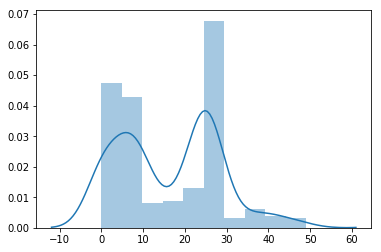

In [97]:
sns.distplot(y)

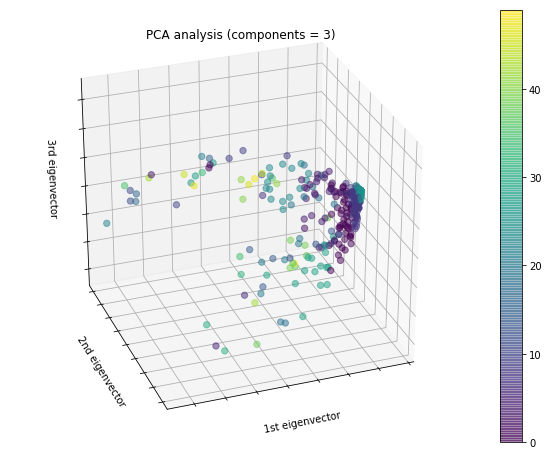

In [99]:
fig = plt.figure(1, figsize=(8, 6))
ax = Axes3D(fig, elev=-150, azim=110)

p = ax.scatter(X_reduced[:, 0], X_reduced[:, 1], X_reduced[:, 2],
               c=y,
               #cmap=plt.cm.Set1,
               #edgecolor='k', 
               s=40, alpha=0.5)

ax.set_title("PCA analysis (components = 3)")
ax.set_xlabel("1st eigenvector")
ax.w_xaxis.set_ticklabels([])
ax.set_ylabel("2nd eigenvector")
ax.w_yaxis.set_ticklabels([])
ax.set_zlabel("3rd eigenvector")
ax.w_zaxis.set_ticklabels([])

fig.colorbar(p)

# XGBoost on seriousness_dff to predict cluster based on clinical trial and drug features

In [101]:
print(seriousness_dff.tail())

         Unnamed: 0 safetyreportid  drugcharacterization   medicinalproduct  \
3705461     4061978       14026748                   2.0  sulfametopyrazine   
3705462     4061979       14026748                   2.0  sulfametopyrazine   
3705463     4061980       14026748                   2.0  sulfametopyrazine   
3705464     4061981       14026748                   2.0  sulfametopyrazine   
3705465     4145867       14194587                   1.0         lonidamine   

         patientonsetage  patientonsetageunit  patientsex  patientweight  \
3705461             53.0                801.0         2.0          73.47   
3705462             53.0                801.0         2.0          73.47   
3705463             53.0                801.0         2.0          73.47   
3705464             53.0                801.0         2.0          73.47   
3705465              NaN                  NaN         NaN            NaN   

         patient_age       reactionmeddrapt receiptdate  serious  \


In [102]:
seriousness_dff.columns

Index(['Unnamed: 0', 'safetyreportid', 'drugcharacterization',
       'medicinalproduct', 'patientonsetage', 'patientonsetageunit',
       'patientsex', 'patientweight', 'patient_age', 'reactionmeddrapt',
       'receiptdate', 'serious', 'seriousnesscongenitalanomali',
       'seriousnessdeath', 'seriousnessdisabling',
       'seriousnesshospitalization', 'seriousnesslifethreatening',
       'seriousnessother', 'serious_count', 'cluster'],
      dtype='object')

In [136]:
features = ['drugcharacterization', 'medicinalproduct', 'patientonsetage', 'patientonsetageunit',
            'patientsex', 'patientweight', 'patient_age',
            'serious', 'seriousnesscongenitalanomali',
            'seriousnessdeath', 'seriousnessdisabling',
            'seriousnesshospitalization', 'seriousnesslifethreatening',
            'seriousnessother', 'serious_count', 'cluster']

In [138]:
sdf = seriousness_dff[features]
sdfn = sdf.dropna()

In [139]:
sdfn.shape

(873102, 16)

In [142]:
y_new = sdfn["cluster"].values
sdfn.drop("cluster", 1, inplace=True)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [143]:
medprod = pd.get_dummies(sdfn["medicinalproduct"]).values

In [144]:
medprod.shape

(873102, 304)

In [145]:
sdfn2 = sdfn.drop("medicinalproduct", 1)

In [146]:
X_new = np.concatenate((sdfn2.values, medprod), axis=1)
X_new.shape

(873102, 318)

In [148]:
X_train, X_test, y_train, y_test = train_test_split(X_new, y_new, test_size=0.33, random_state=42)

In [149]:
X_train.shape

(584978, 318)

In [150]:
X_test.shape

(288124, 318)

In [151]:
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

In [153]:
# specify parameters via map
param = {'max_depth':6, 
         'eta':0.3, 
         'silent':0, 
         'objective':'multi:softmax',
         'num_class':50}

# n estimators
num_round = 10

bst = xgb.train(param, dtrain, num_round)

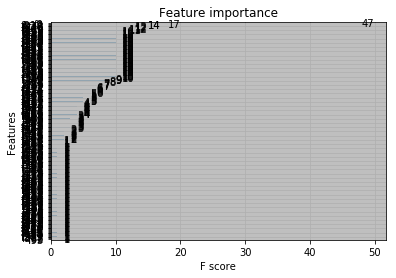

In [154]:
xgb.plot_importance(bst)

In [155]:
"""
fig = plt.figure(1, figsize=(8, 6))
ax = Axes3D(fig, elev=-150, azim=110)

p = ax.scatter(X_train[:, 0], X_train[:, 2], X_train[:, 4],
               c=y_train,
               #cmap=plt.cm.Set1,
               #edgecolor='k', 
               s=40, alpha=0.2)

ax.set_title("PCA analysis (components = 10)")
ax.set_xlabel("f0")
ax.w_xaxis.set_ticklabels([])
ax.set_ylabel("f2")
ax.w_yaxis.set_ticklabels([])
ax.set_zlabel("f4")
ax.w_zaxis.set_ticklabels([])

fig.colorbar(p)
"""

'\nfig = plt.figure(1, figsize=(8, 6))\nax = Axes3D(fig, elev=-150, azim=110)\n\np = ax.scatter(X_train[:, 0], X_train[:, 2], X_train[:, 4],\n               c=y_train,\n               #cmap=plt.cm.Set1,\n               #edgecolor=\'k\', \n               s=40, alpha=0.2)\n\nax.set_title("PCA analysis (components = 10)")\nax.set_xlabel("f0")\nax.w_xaxis.set_ticklabels([])\nax.set_ylabel("f2")\nax.w_yaxis.set_ticklabels([])\nax.set_zlabel("f4")\nax.w_zaxis.set_ticklabels([])\n\nfig.colorbar(p)\n'

In [ ]:
######## prediction

In [156]:
ypred = bst.predict(dtest)

In [157]:
ypred

array([34., 15., 17., ..., 11., 13., 16.], dtype=float32)

In [158]:
ypred.shape

(288124,)

In [159]:
y_test.shape

(288124,)

In [160]:
np.mean(ypred == y_test)

0.9986707112215574